Por Miguel Ángel Castañeda Martínez

Cuando empecé mi trayectoria como científico de datos tenía escaso conocimiento de lenguajes de programación, modelos de aprendizaje de máquina, análisis exploratorio de datos, etc. En un inicio imaginaba que la analítica de datos iba más por el camino de los sistemas, el poder computacional, y los algoritmos, pero nunca imaginé que tuviera algo que ver con estadística. Para mí la estadística era una materia más con la que debía cumplir en la carrera, la veía como algo arcaico y tedioso. Poco me imaginaba en que años después terminaría siendo de mis temas favoritos, que encontraría fascinante el inmenso mundo en el que me adentraría.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Visualización inicial

Primero se hace una inspección rápida de las encuestas para identificar variables de interés

In [2]:
poll_data = pd.read_stata('./pew_research_center_june_elect_wknd_data.dta')

Se trabajará únicamente con las variables [`state`, `survey`, `ideo`].

- `state`: Estado en el que se realizaró la encuesta.
- `survey`: Identificador de la encuesta aplicada en cada registro.
- `ideo`: Ideología política del encuestado.

**Paso 1**: Se agrupan los datos por estado para extraer las encuestas que se
aplicaron a cada uno.

In [3]:
state = poll_data.groupby(by='state').count()
state.reset_index(inplace=True)
state = state[['state', 'survey']]

**Paso 2**: Se agrupa por estado e ideología política para poder filtrar a las
encuestas que son _very liberal_.

In [4]:
ideo = poll_data.groupby(by=['state','ideo']).count()
ideo.reset_index(inplace=True)
ideo = ideo[['state', 'ideo', 'survey']]
very_liberal = ideo.loc[ideo['ideo'] == 'very liberal']

**Paso 3**: Se unen los dos conjuntos de datos agrupados.

In [5]:
prop = pd.merge(left=state,
 right=very_liberal,
 how='left',
 on='state',
 suffixes=('_total','_very_lib'))

**Paso 4**: Se crean variables con la proporción de _very liberal_ de máxima verosimilitud para cada estado.

In [6]:
prop['prop_mle'] = prop['survey_very_lib'] / prop['survey_total']
#Se eliminan estados que no son de interés
prop = prop[~prop['state'].isin(['washington dc', 'hawaii', 'alaska'])]
prop.head()

,state,survey_total,ideo,survey_very_lib,prop_mle
0,alabama,624,very liberal,30,0.048077
1,arizona,542,very liberal,28,0.051661
2,arkansas,307,very liberal,7,0.022801
3,california,2854,very liberal,179,0.062719
4,colorado,468,very liberal,27,0.057692


**Paso 5**: Se visualiza el comportamiento del número de encuestas realizadas por estado contra el estimador de máxima verosimilitud.

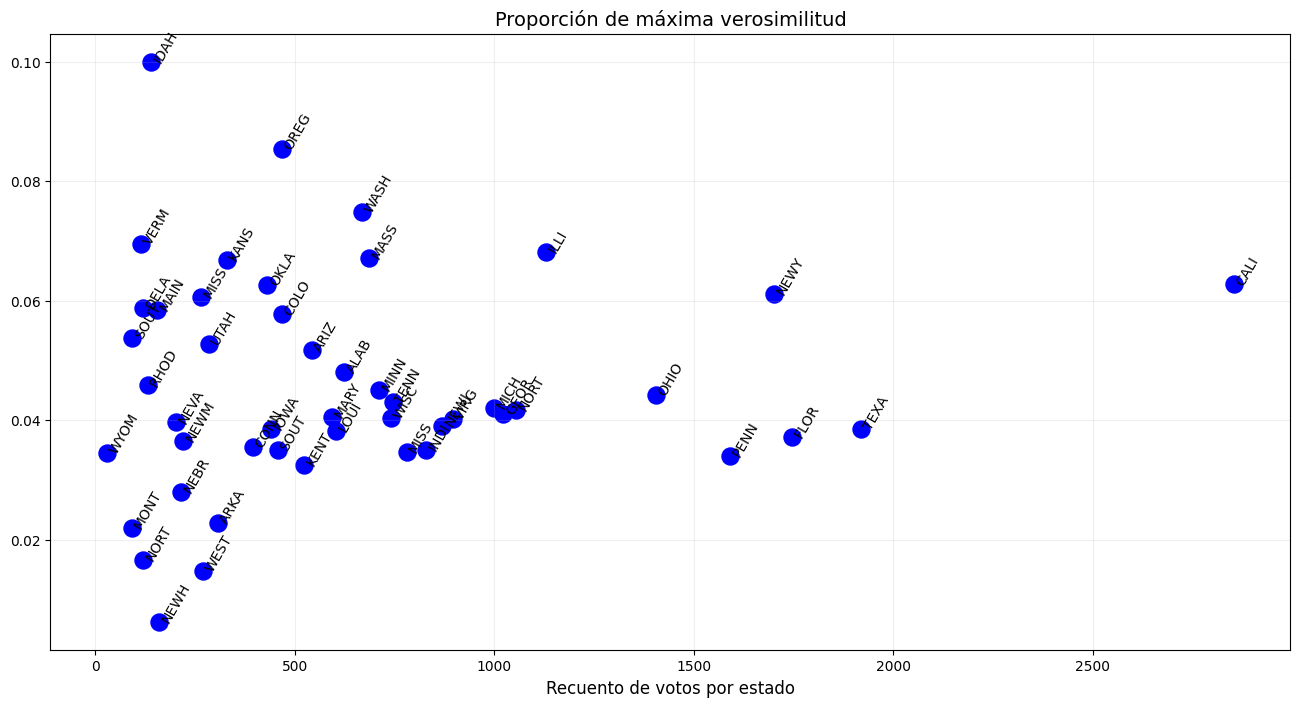

In [7]:
plt.figure(figsize=(16,8))
plt.scatter(x=prop['survey_total'], y=prop['prop_mle'], s=150, color='blue')
for idx in prop.index:
    x = prop.loc[idx]['survey_total']
    y = prop.loc[idx]['prop_mle']
    s = prop.loc[idx]['state'].upper().replace(' ', '')[0:4]
    plt.text(x=x, y=y, s=s, fontsize=10, rotation=60)
plt.title('Proporción de máxima verosimilitud', fontsize=14)
plt.xlabel('Recuento de votos por estado', fontsize=12)
plt.grid(alpha=0.2)
plt.show()

Ahora revisamos los datos de la votación real, para lo cual se realizan los siguientes pasos:

**Paso 1**: Se une al conjunto de datos el porcentaje de votos por Obama de cada estado.

In [8]:
results = pd.read_csv('./2008ElectionResult.csv')

#se descartan estados que no son de interés
results = results[~results['state'].isin(['District of Columbia', 'Hawaii', 'Alaska'])]
results['state'] = results['state'].str.lower()

                  
prop = pd.merge(left=prop,
                right=results[['state', 'vote_Obama_pct']],
                how='left',
                on='state')

**Paso 2**: Se comparan los votos de obama con los que son _very liberal_

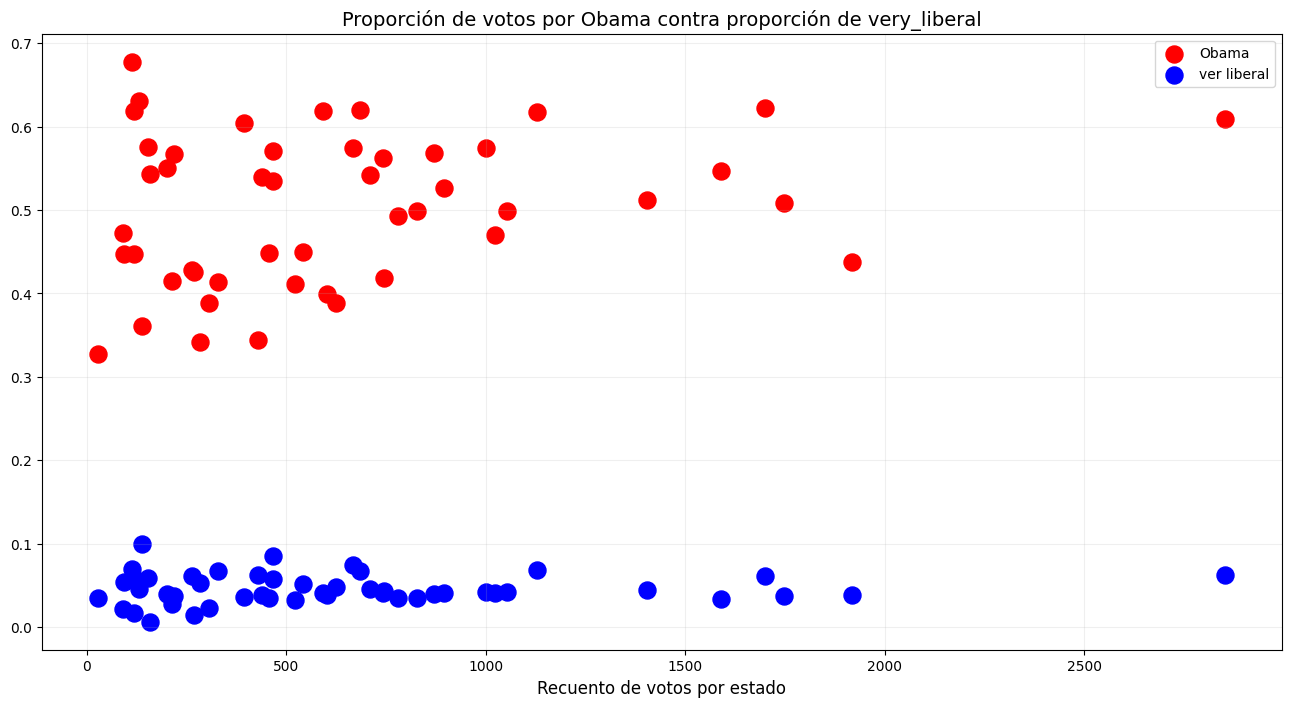

In [9]:
plt.figure(figsize=(16,8))

plt.scatter(x=prop['survey_total'], y=prop['vote_Obama_pct']/100, color='red', s=150, label='Obama')
plt.scatter(x=prop['survey_total'], y=prop['prop_mle'], color='blue', s=150, label='ver liberal')

plt.title('Proporción de votos por Obama contra proporción de very_liberal', fontsize=14)
plt.xlabel('Recuento de votos por estado', fontsize=12)
plt.grid(alpha=0.2)
plt.legend()

plt.show()

Los datos muestran un comportamiento similar en el eje del recuento de votos por estado, sin embargo, el hecho de que se encuentren en escalas diferentes dificulta el poder encontrar algún patrón o similitud entre ambos conjuntos.

Para resolver lo anterior, visualizamos los datos en la misma escala de visual, pero respetando su orden de magintud.

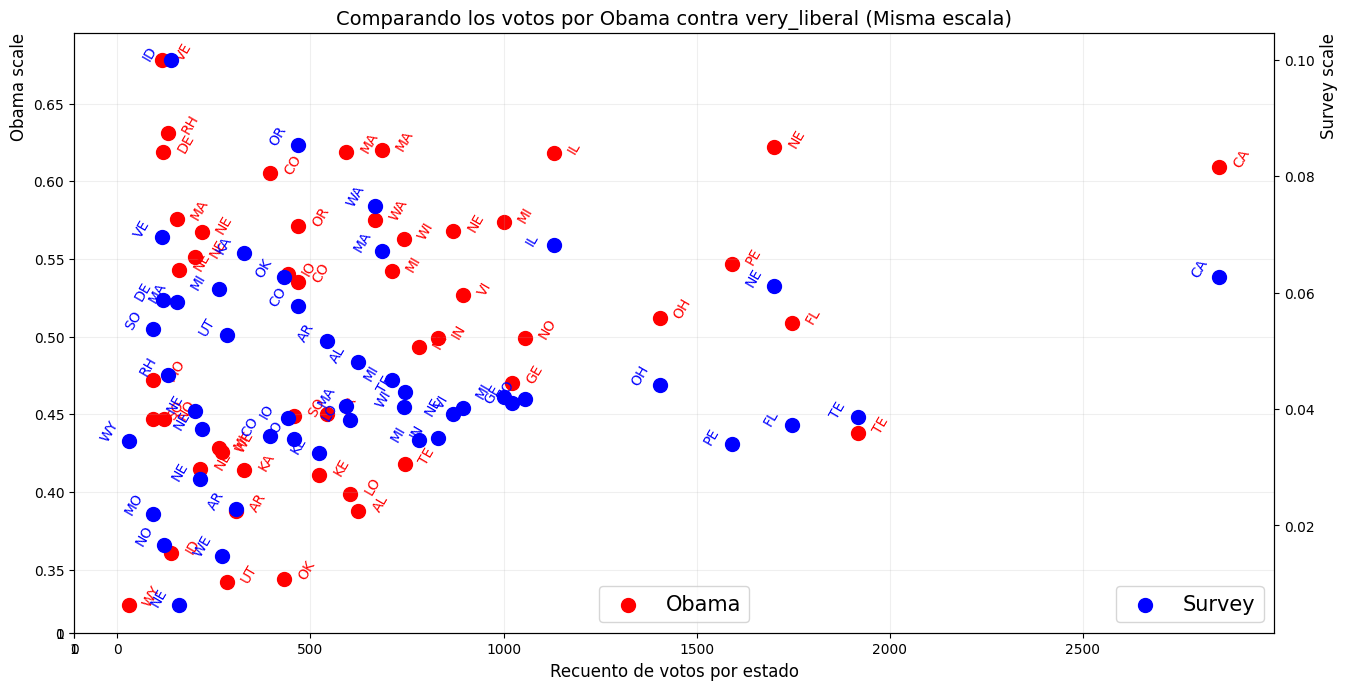

In [10]:
# Plot two lines with different scales on the same plot
fig = plt.figure(figsize=(12,6))
s = 100

#Gráficas
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([0, 0, 0, 0]) #
ax2 = ax1.twinx()
lns1 = ax1.scatter(x=prop['survey_total'], y=prop['vote_Obama_pct']/100, color='red', s=s, label='Obama')
lns2 = ax2.scatter(x=prop['survey_total'], y=prop['prop_mle'], color='blue', s=s, label='Survey')

#Anotaciones y estilo
ax1.set_xlabel('Recuento de votos por estado', fontsize=12)
ax1.set_ylabel('Obama scale', fontsize=12, loc='top')
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Survey scale', fontsize=12,  loc='top')
ax1.legend(loc=8, fontsize=15); ax2.legend(loc=4, fontsize=15)

for idx in prop.index:
    x1 = prop.loc[idx]['survey_total'] + 30
    y1 = prop.loc[idx]['vote_Obama_pct']/100
    s1 = prop.loc[idx]['state'].upper().replace(' ', '')[0:2]
    ax1.text(x=x1, y=y1, s=s1, fontsize=10, rotation=60, color='red')
    
    x2 = prop.loc[idx]['survey_total'] - 80
    y2 = prop.loc[idx]['prop_mle']
    s2 = prop.loc[idx]['state'].upper().replace(' ', '')[0:2]
    ax2.text(x=x2, y=y2, s=s2, fontsize=10, rotation=60, color='blue')
    
plt.title('Comparando los votos por Obama contra very_liberal (Misma escala)', fontsize=14)
ax1.grid(alpha=0.2)
    
plt.show()

Con la visualización anterior se vuelve evidente que el número de votos que tuvo Obama por estado sigue un patrón sumamente similar a la proporción de personas por estado que se consideran _very liberal_.

---